[Go to Yizhen Peng part](#YizhenPeng)

# Import data

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

train_features = pd.read_csv('training_set_features.csv')
train_labels = pd.read_csv('training_set_labels.csv')
test_features = pd.read_csv('test_set_features.csv')


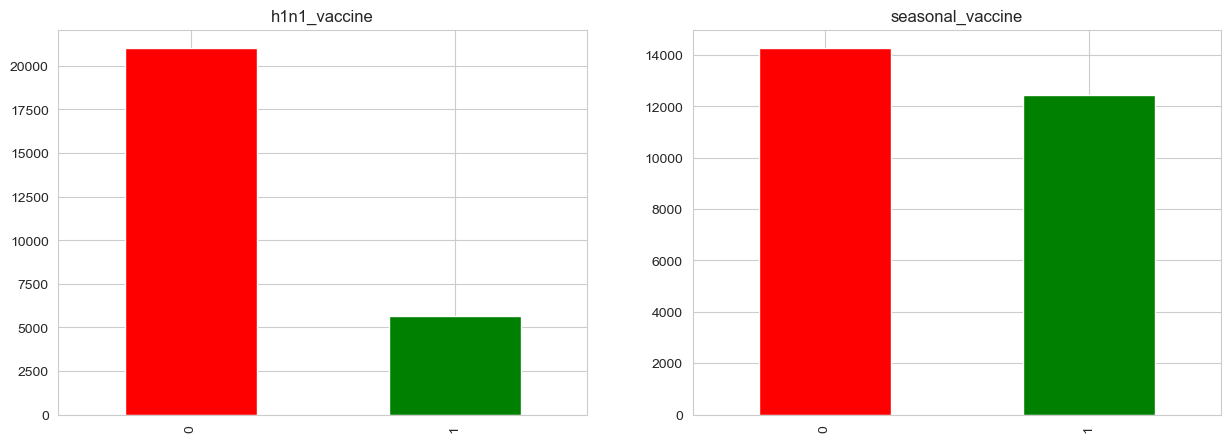

In [2]:
# plot bar chart to show the distribution of labels
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# use different color to represent different label
train_labels['h1n1_vaccine'].value_counts().plot(kind='bar', ax=axes[0], title='h1n1_vaccine', color=['red', 'green'])
train_labels['seasonal_vaccine'].value_counts().plot(kind='bar', ax=axes[1], title='seasonal_vaccine', color=['red', 'green'])
plt.show()

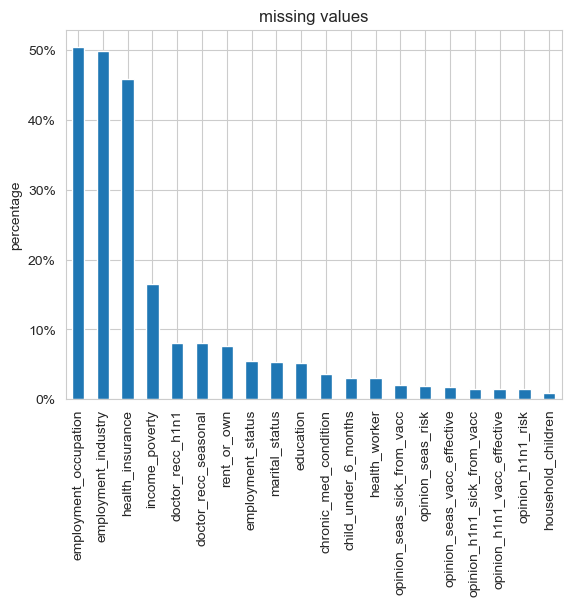

In [3]:
import matplotlib.ticker as mtick
# count missing values
df_missing_values_percentage =train_features.isnull().sum().sort_values(ascending=False)[:20]/len(train_features)
# draw missing values percentage bar chart
df_missing_values_percentage.plot(kind='bar')
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.title('missing values')
plt.ylabel('percentage')
plt.show()

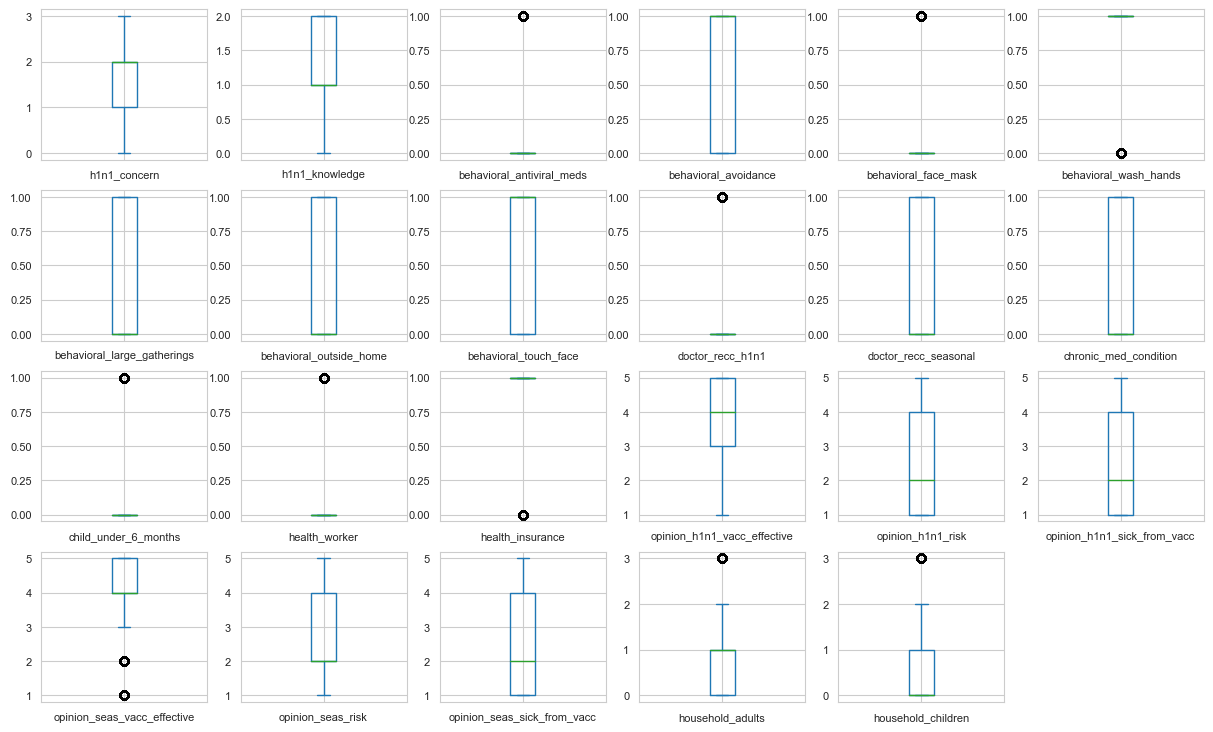

In [4]:
# plot boxplot
numerical_columns = train_features.select_dtypes(include=['float64']).columns
train_features[numerical_columns].plot(kind='box', subplots=True, layout=(4, 6), figsize=(15, 9), fontsize=8)
plt.show()

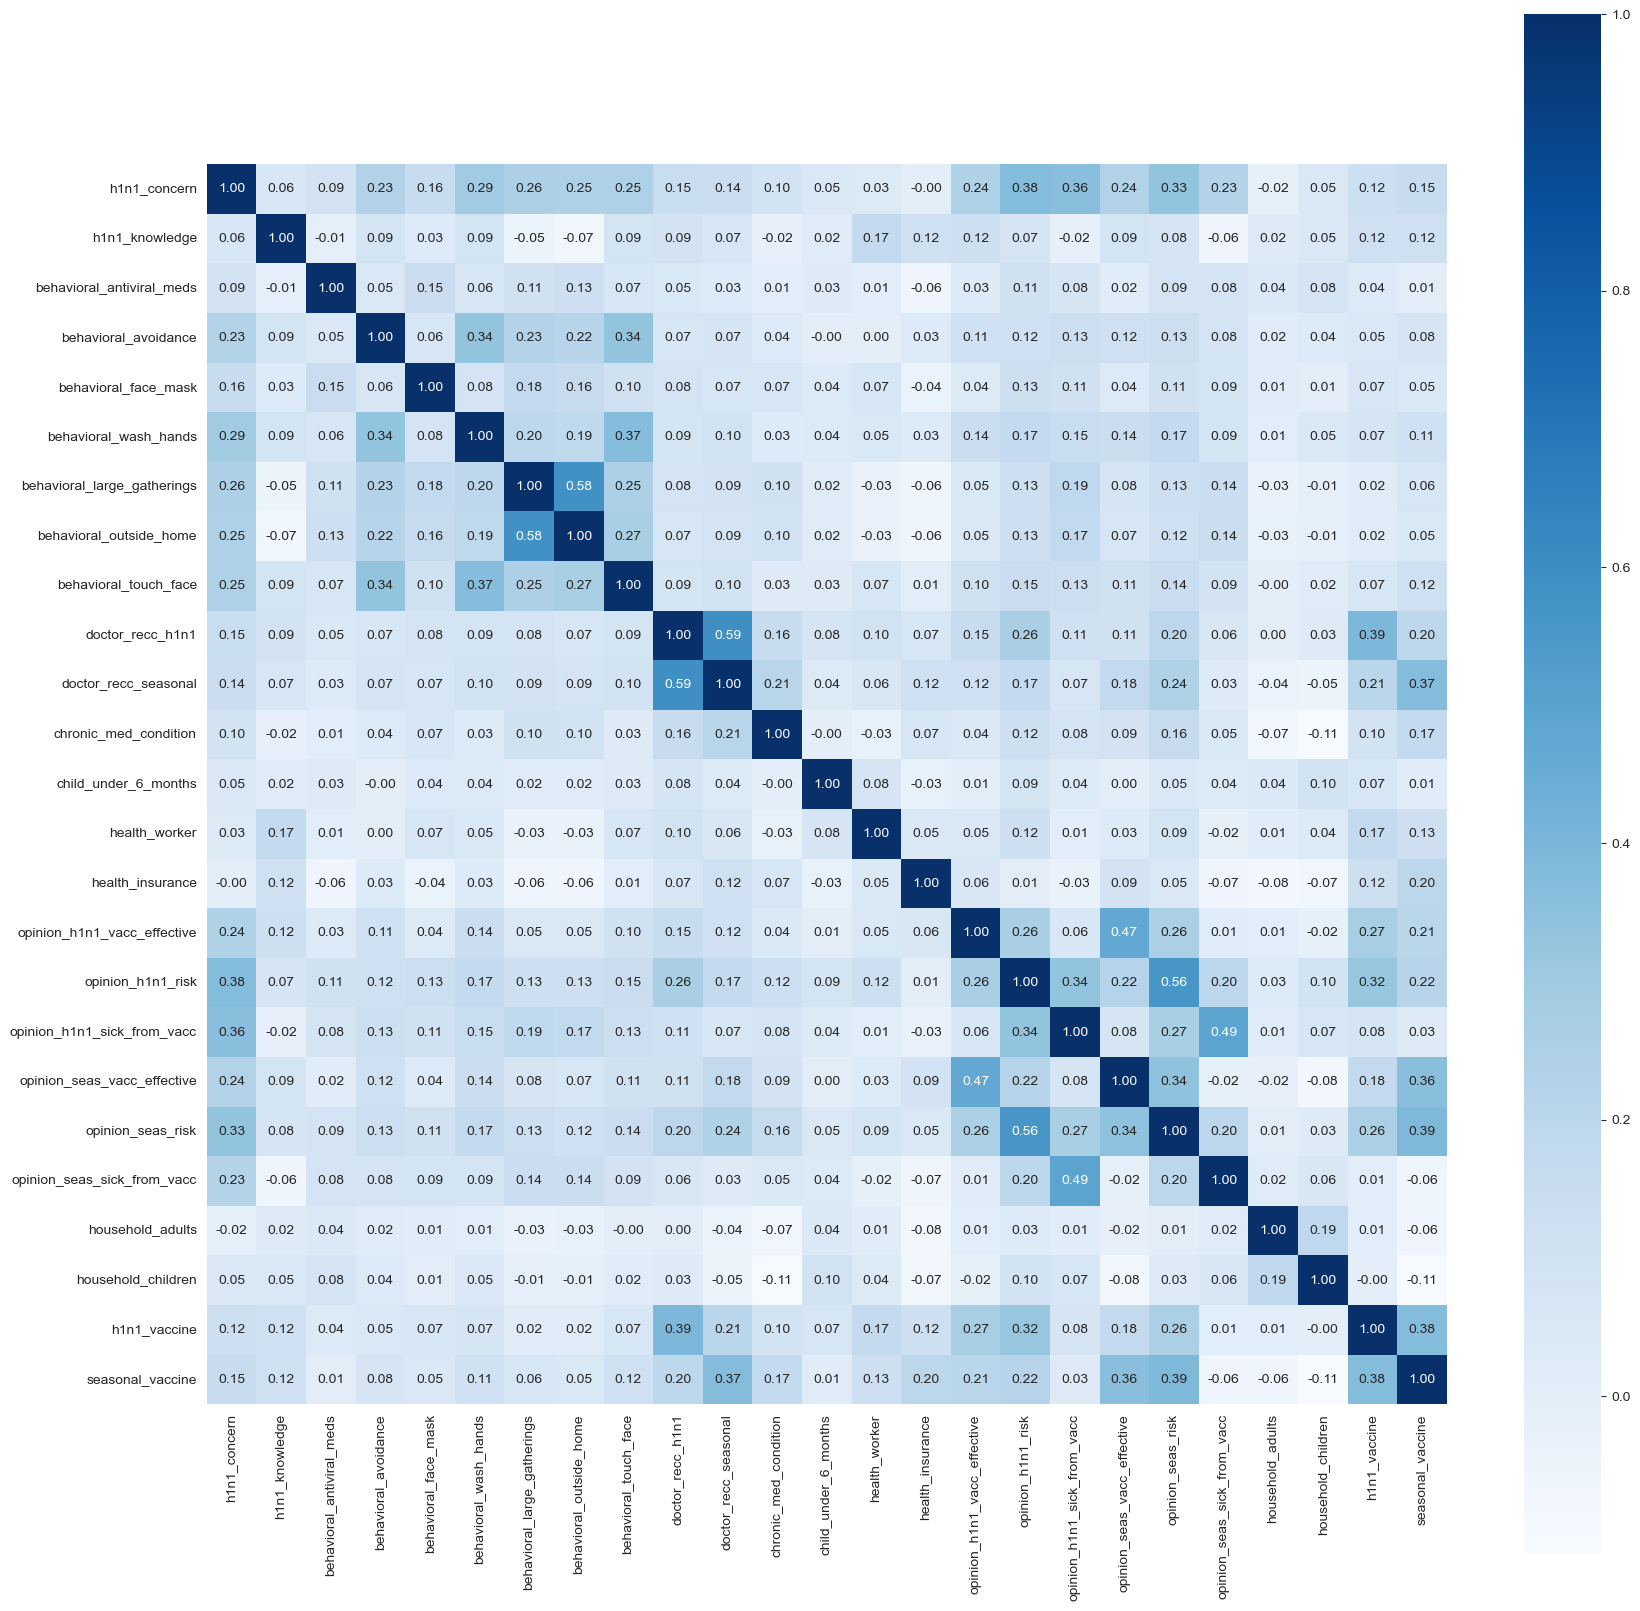

In [5]:
# plot heatmap
import seaborn as sns
heatmap_data = pd.concat([train_features, train_labels], axis=1).drop('respondent_id', axis=1)
plt.figure(figsize=(20, 20))
sns.heatmap(heatmap_data.corr(), annot=True, fmt='.2f', square=True, cmap='Blues')
plt.show()

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Encode categorical variables
le = LabelEncoder()
feature_inportance = train_features.copy()
for column in feature_inportance.columns:
    if feature_inportance[column].dtype == 'object':
        feature_inportance[column] = feature_inportance[column].astype(str)
        feature_inportance[column] = le.fit_transform(feature_inportance[column])

# Impute missing values with the mean for numerical columns
num_imputer = SimpleImputer(strategy='mean')
numerical_columns = feature_inportance.select_dtypes(include=['int64', 'float64']).columns
feature_inportance[numerical_columns] = num_imputer.fit_transform(feature_inportance[numerical_columns])

# Function to calculate feature importances for a given target variable
def calculate_feature_importances(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    importances = rf.feature_importances_
    return pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Calculate feature importances for both target variables
importances_h1n1 = calculate_feature_importances(feature_inportance, train_labels['h1n1_vaccine'])
importances_seasonal = calculate_feature_importances(feature_inportance, train_labels['seasonal_vaccine'])

print("Feature importances for h1n1_vaccine:")
print(importances_h1n1)
print("Feature importances for seasonal_vaccine:")
print(importances_seasonal)

# Set a threshold for feature importance (you can adjust this value based on your specific problem)
threshold = 0.01

# Identify unimportant features
unimportant_features_h1n1 = importances_h1n1[importances_h1n1 < threshold].index
unimportant_features_seasonal = importances_seasonal[importances_seasonal < threshold].index
print("Unimportant features for h1n1_vaccine:")
print(unimportant_features_h1n1)
print("Unimportant features for seasonal_vaccine:")
print(unimportant_features_seasonal)

# Check if 'employment_industry', 'employment_occupation', and 'health_insurance' are unimportant
features_to_check = ['employment_industry', 'employment_occupation', 'health_insurance']
unimportant_checked_features_h1n1 = [feature for feature in features_to_check if feature in unimportant_features_h1n1]
unimportant_checked_features_seasonal = [feature for feature in features_to_check if feature in unimportant_features_seasonal]

if unimportant_checked_features_h1n1:
    print("Unimportant checked features for h1n1_vaccine:")
    print(unimportant_checked_features_h1n1)
else:
    print("All checked features are important for h1n1_vaccine.")

if unimportant_checked_features_seasonal:
    print("Unimportant checked features for seasonal_vaccine:")
    print(unimportant_checked_features_seasonal)
else:
    print("All checked features are important for seasonal_vaccine.")

Feature importances for h1n1_vaccine:
doctor_recc_h1n1               0.101279
respondent_id                  0.078692
opinion_h1n1_risk              0.069636
health_insurance               0.061872
opinion_h1n1_vacc_effective    0.055302
hhs_geo_region                 0.046420
opinion_seas_risk              0.040587
employment_occupation          0.038484
employment_industry            0.034149
age_group                      0.032126
opinion_h1n1_sick_from_vacc    0.027188
opinion_seas_vacc_effective    0.026801
h1n1_concern                   0.026715
education                      0.025987
opinion_seas_sick_from_vacc    0.024791
doctor_recc_seasonal           0.023216
census_msa                     0.022720
income_poverty                 0.022246
household_adults               0.021946
h1n1_knowledge                 0.020571
household_children             0.018375
health_worker                  0.016440
race                           0.016323
sex                            0.013946
ma

# Data preprocessing

In [8]:
from scipy import stats
def preprocess_data(features, is_train=True, encoders=None):
    # Drop 'respondent_id' if it's in features
    if 'respondent_id' in features.columns:
        features.drop(['respondent_id'], axis=1, inplace=True)
        # features.drop(['employment_industry', 'employment_occupation'], axis=1, inplace=True)

    # Columns to be label encoded
    label_columns = [
        'age_group',
        'education',
        'income_poverty',
        'h1n1_concern',
        'h1n1_knowledge',
        'opinion_h1n1_vacc_effective',
        'opinion_h1n1_risk',
        'opinion_h1n1_sick_from_vacc',
        'opinion_seas_vacc_effective',
        'opinion_seas_risk',
        'opinion_seas_sick_from_vacc',
    ]

    # Columns to be one-hot encoded
    one_hot_columns = [
        'race',
        'sex',
        'marital_status',
        'rent_or_own',
        'employment_status',
        'hhs_geo_region',
        'census_msa',
        'employment_industry',
        'employment_occupation',
    ]

    # Handle missing values
    features.fillna({'health_insurance': 0, 'child_under_6_months': 0}, inplace=True)

    # numerical columns is excluded from label_columns and one_hot_columns
    numerical_columns = features[features.columns.difference(label_columns + one_hot_columns)].columns.tolist()
    # Compute the mean only for numerical columns
    features[numerical_columns] = features[numerical_columns].fillna(features[numerical_columns].mean())

    features.fillna('unknown', inplace=True)

    if is_train:
        encoders = {}

        # Perform label encoding for training data
        for column in label_columns:
            le = LabelEncoder()
            unique_values = features[column].unique().tolist()
            unique_values.append('unknown')
            le.fit(unique_values)
            features[column] = le.transform(features[column])
            encoders[column] = le

        # Perform one-hot encoding for training data
        ohe = OneHotEncoder(sparse_output=False)
        one_hot_encoded = ohe.fit_transform(features[one_hot_columns])
        encoders['one_hot'] = ohe
        features = features.drop(one_hot_columns, axis=1)
        features = pd.concat([features, pd.DataFrame(one_hot_encoded, columns=ohe.get_feature_names_out(one_hot_columns))], axis=1)
    else:
        # Perform label encoding for test data
        for column in label_columns:
            features[column] = features[column].apply(lambda x: x if x in set(encoders[column].classes_) else 'unknown')
            features[column] = encoders[column].transform(features[column])

        # Perform one-hot encoding for test data
        one_hot_encoded = encoders['one_hot'].transform(features[one_hot_columns])
        features = features.drop(one_hot_columns, axis=1)
        features = pd.concat([features, pd.DataFrame(one_hot_encoded, columns=encoders['one_hot'].get_feature_names_out(one_hot_columns))], axis=1)

    # Standardization
    numerical_columns = features.select_dtypes(include=['int64', 'float64']).columns
    if is_train:
        # Perform standardization for training data
        scaler = StandardScaler()
        features[numerical_columns] = scaler.fit_transform(features[numerical_columns])
        encoders['scaler'] = scaler
    else:
        # Perform standardization for test data
        features[numerical_columns] = encoders['scaler'].transform(features[numerical_columns])

    return features, encoders

In [10]:
# deal with data Imbalance method: SMOTE
from imblearn.over_sampling import SMOTE

def deal_with_imbalance(X, y):
    smote = SMOTE(random_state=42)
    X, y = smote.fit_resample(X, y)
    return X, y

# Construct neural network structure

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# seasonal (100, 100), lbfgs, 50
class PyTorchMLPClassifier:
    def __init__(self, hidden_size=50, output_size=1, batch_size=50, learning_rate=0.0001, num_epochs=200,
                 lr_decay_step_size=1, lr_decay_gamma=0.9, dropout_rate=0.2, random_state=None):
        self.input_size = None
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.dropout_rate = dropout_rate
        self.random_state = random_state

        self.model = None
        self.criterion = nn.BCELoss()
        self.optimizer = None
        self.scheduler = None

        self.train_loss_history = []
        self.valid_loss_history = []
        self.lr_history = []

    class Net(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super().__init__()
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(hidden_size, output_size)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            out = self.fc1(x)
            out = self.sigmoid(out)
            out = self.fc2(out)
            out = self.sigmoid(out)
            return out

    def fit(self, X, y, X_valid=None, y_valid=None):
        # Set input_size based on X's number of features
        self.input_size = X.shape[1]

        # Create model, optimizer and scheduler after input_size is determined
        self.model = self.Net(self.input_size, self.hidden_size, self.output_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=self.num_epochs, eta_min=self.learning_rate/100)

        X_train_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32)
        y_train_tensor = torch.tensor(y.to_numpy(), dtype=torch.float32).unsqueeze(1)  # Add extra dimension
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.num_epochs):
            self.model.train()
            train_loss = 0

            for batch_x, batch_y in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(batch_x)
                loss = self.criterion(outputs, batch_y)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()

            # Record learning rate
            self.lr_history.append(self.scheduler.get_last_lr()[0])

            # Record train loss
            self.train_loss_history.append(train_loss / len(train_loader))

            # If validation data is provided, compute and record validation loss
            if X_valid is not None and y_valid is not None:
                self.model.eval()
                with torch.no_grad():
                    X_valid_tensor = torch.tensor(X_valid.to_numpy(), dtype=torch.float32)
                    y_valid_tensor = torch.tensor(y_valid.to_numpy(), dtype=torch.float32).unsqueeze(1)
                    outputs = self.model(X_valid_tensor)
                    valid_loss = self.criterion(outputs, y_valid_tensor)
                self.valid_loss_history.append(valid_loss.item())

            self.scheduler.step()


    def predict_proba(self, X):
        X_test_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32)
        self.model.eval()

        with torch.no_grad():
            outputs = self.model(X_test_tensor)
        proba = outputs.numpy()
        return np.hstack([1 - proba, proba])


    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)


    def score(self, X, y):
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y)
        return accuracy

    def get_params(self, deep=True):
        # Suppose this estimator has parameters "alpha" and "recursive"
        return {"hidden_size": self.hidden_size, "output_size": self.output_size, "learning_rate": self.learning_rate, "num_epochs": self.num_epochs}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    import matplotlib.pyplot as plt

    def plot_lr_history(clf):
        plt.plot(clf.lr_history)
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate History')
        plt.show()

    def plot_loss_history(clf):
        plt.plot(clf.train_loss_history, label='Train_loss')
        if clf.valid_loss_history:
            plt.plot(clf.valid_loss_history, label='Val_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss History')
        plt.legend()
        plt.show()

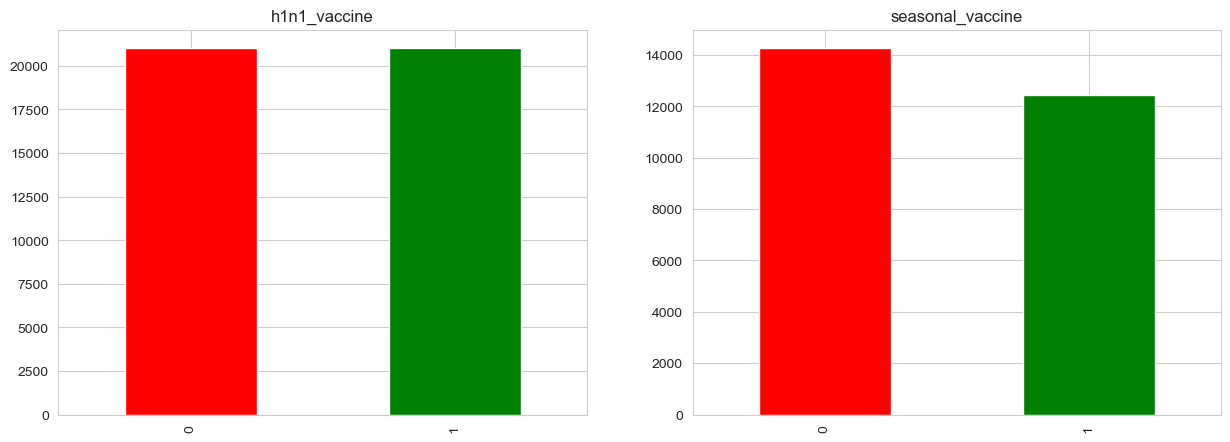

In [12]:
# data preprocessing
X_f, encoders = preprocess_data(train_features)
y_table_h1n1 = train_labels['h1n1_vaccine']
y_table_seasonal = train_labels['seasonal_vaccine']

# deal with imbalance
X_f_h1n1_smote, y_table_h1n1_smote = deal_with_imbalance(X_f, y_table_h1n1)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# draw the distribution of the target variable
y_table_h1n1_smote.value_counts().plot(kind='bar', ax=axes[0], title='h1n1_vaccine', color=['red', 'green'])
y_table_seasonal.value_counts().plot(kind='bar', ax=axes[1], title='seasonal_vaccine', color=['red', 'green'])
plt.show()

In [13]:
# distribution of the features
X_train_h1n1, X_val_h1n1, y_train_h1n1, y_val_h1n1 = train_test_split(X_f_h1n1_smote, y_table_h1n1_smote, test_size=0.2, random_state=42)
X_train_seasonal, X_val_seasonal, y_train_seasonal, y_val_seasonal = train_test_split(X_f, y_table_seasonal, test_size=0.2, random_state=42)

model_h1n1 = PyTorchMLPClassifier()
model_seasonal = PyTorchMLPClassifier()

# define the model
model_h1n1.fit(X_train_h1n1, y_train_h1n1, X_val_h1n1, y_val_h1n1)
model_seasonal.fit(X_train_seasonal, y_train_seasonal, X_val_seasonal,y_val_seasonal)

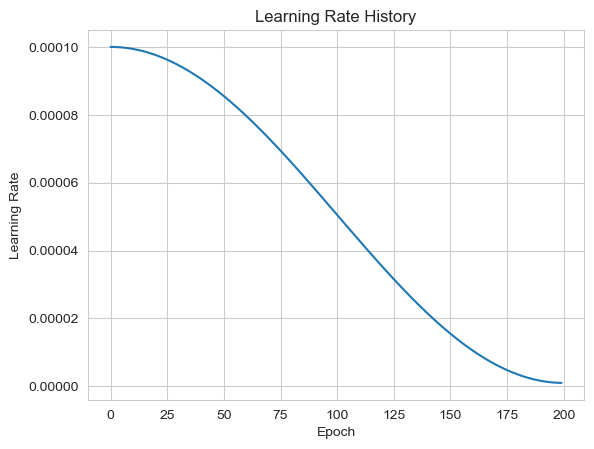

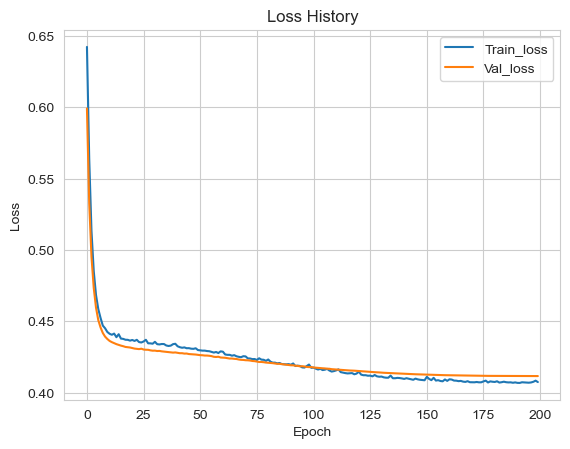

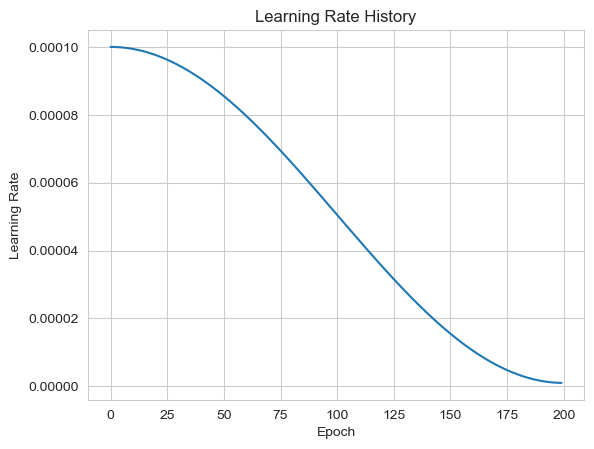

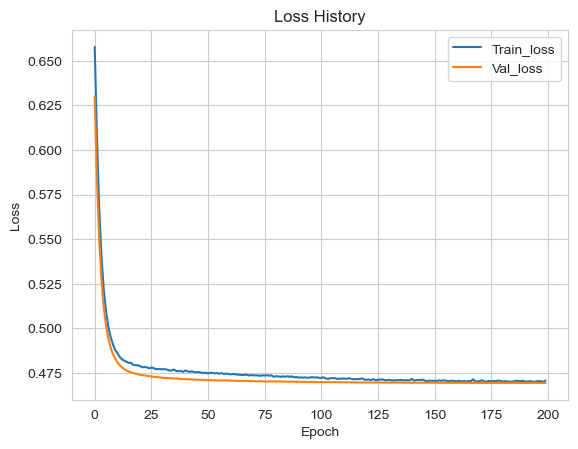

In [14]:
model_h1n1.plot_lr_history()
model_h1n1.plot_loss_history()
model_seasonal.plot_lr_history()
model_seasonal.plot_loss_history()

In [15]:
# define roc curve method
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(y_val_h1n1, y_prob_h1n1, y_val_seasonal, y_prob_seasonal):
    # Compute ROC curve and ROC area for each target
    fpr_h1n1, tpr_h1n1, _ = roc_curve(y_val_h1n1, y_prob_h1n1)
    roc_auc_h1n1 = auc(fpr_h1n1, tpr_h1n1)

    fpr_seasonal, tpr_seasonal, _ = roc_curve(y_val_seasonal, y_prob_seasonal)
    roc_auc_seasonal = auc(fpr_seasonal, tpr_seasonal)

    # Plot ROC curve for h1n1
    plt.figure(figsize=(8,8))
    plt.plot(fpr_h1n1, tpr_h1n1, color='b', lw=2, label=f'ROC curve for h1n1 (area = {roc_auc_h1n1:.3f})')

    # Plot ROC curve for seasonal
    plt.plot(fpr_seasonal, tpr_seasonal, color='r', lw=2, label=f'ROC curve for seasonal (area = {roc_auc_seasonal:.3f})')

    # Plot settings
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

Classification report for h1n1 vaccine
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      4287
           1       0.81      0.82      0.81      4127

    accuracy                           0.82      8414
   macro avg       0.82      0.82      0.82      8414
weighted avg       0.82      0.82      0.82      8414

Classification report for seasonal vaccine
              precision    recall  f1-score   support

           0       0.79      0.82      0.80      2891
           1       0.78      0.75      0.76      2451

    accuracy                           0.79      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.79      0.79      0.78      5342



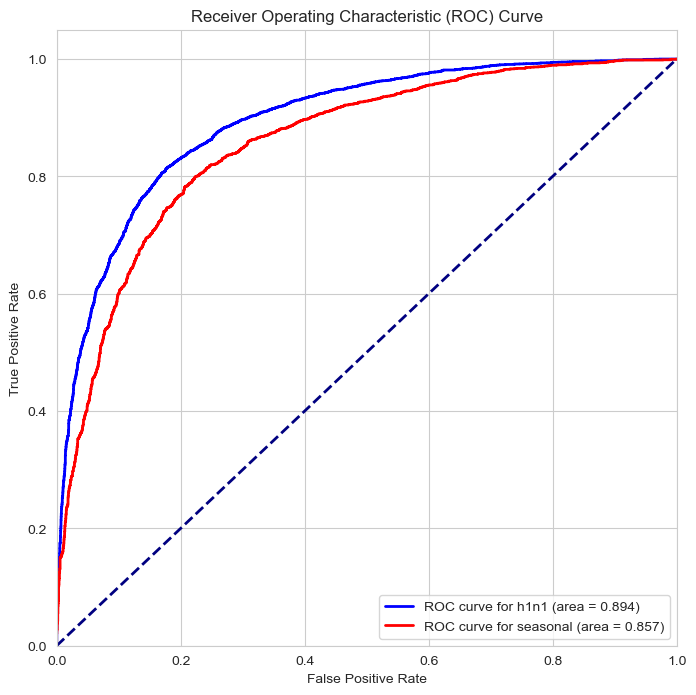

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities
y_prob_h1n1 = model_h1n1.predict_proba(X_val_h1n1)[:,1]
y_prob_seasonal = model_seasonal.predict_proba(X_val_seasonal)[:,1]

# print classification report
print("Classification report for h1n1 vaccine")
print(classification_report(y_val_h1n1, model_h1n1.predict(X_val_h1n1)))
print("Classification report for seasonal vaccine")
print(classification_report(y_val_seasonal, model_seasonal.predict(X_val_seasonal)))

# Plot ROC curve
plot_roc_curve(y_val_h1n1, y_prob_h1n1, y_val_seasonal, y_prob_seasonal)

In [17]:
# # test catboost model
# from sklearn.model_selection import GridSearchCV
# from catboost import CatBoostClassifier
#
# # use grid search to find the best parameters
# params = {'iterations': [500, 1000, 1500],
#           'depth': [4, 6, 8],
#           'learning_rate': [0.01, 0.05, 0.1]}
#
# model_h1n1 = CatBoostClassifier()
# model_seasonal = CatBoostClassifier()
#
# grid_h1n1 = GridSearchCV(model_h1n1, params, scoring='accuracy', cv=5, n_jobs=-1)
# grid_seasonal = GridSearchCV(model_seasonal, params, scoring='accuracy', cv=5, n_jobs=-1)
#
# grid_h1n1.fit(X_train_h1n1, y_train_h1n1)
# grid_seasonal.fit(X_train_seasonal, y_train_seasonal)
#
# print("Best parameters for h1n1: ", grid_h1n1.best_params_)
# print("Best parameters for seasonal: ", grid_seasonal.best_params_)

In [18]:
# use the best parameters to train the model
# Best parameters for h1n1:  {'depth': 6, 'iterations': 1500, 'learning_rate': 0.05}
# Best parameters for seasonal:  {'depth': 6, 'iterations': 500, 'learning_rate': 0.01}

from catboost import CatBoostClassifier

model_c_h1n1 = CatBoostClassifier(depth=6, iterations=500, learning_rate=0.05)
model_c_seasonal = CatBoostClassifier(depth=6, iterations=1500, learning_rate=0.01)

model_c_h1n1.fit(X_train_h1n1, y_train_h1n1, verbose=False)
model_c_seasonal.fit(X_train_seasonal, y_train_seasonal, verbose=False)

Classification report for h1n1 vaccine
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      4287
           1       0.81      0.82      0.81      4127

    accuracy                           0.82      8414
   macro avg       0.82      0.82      0.82      8414
weighted avg       0.82      0.82      0.82      8414

Classification report for seasonal vaccine
              precision    recall  f1-score   support

           0       0.79      0.82      0.80      2891
           1       0.78      0.75      0.76      2451

    accuracy                           0.79      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.79      0.79      0.78      5342



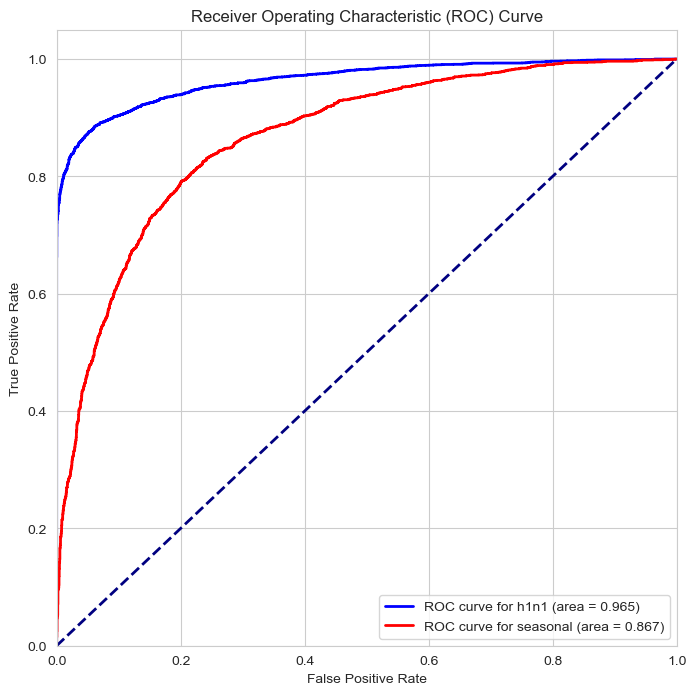

In [19]:
# predict probabilities
y_prob_h1n1 = model_c_h1n1.predict_proba(X_val_h1n1)[:,1]
y_prob_seasonal = model_c_seasonal.predict_proba(X_val_seasonal)[:,1]

# print classification report
print("Classification report for h1n1 vaccine")
print(classification_report(y_val_h1n1, model_h1n1.predict(X_val_h1n1)))
print("Classification report for seasonal vaccine")
print(classification_report(y_val_seasonal, model_seasonal.predict(X_val_seasonal)))

# Plot ROC curve
plot_roc_curve(y_val_h1n1, y_prob_h1n1, y_val_seasonal, y_prob_seasonal)

# Ablation experiment

In [20]:
from sklearn.base import clone

def train_and_evaluate_model(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    probabilities = model.predict_proba(X_val)[:, 1]
    preds = model.predict(X_val)
    fpr, tpr, _ = roc_curve(y_val, probabilities)
    roc_auc = auc(fpr, tpr)
    return model, roc_auc, preds, fpr, tpr


def plot_roc_curves(ax, fpr_h1n1, tpr_h1n1, roc_auc_h1n1, fpr_seasonal, tpr_seasonal, roc_auc_seasonal, group_name):
    ax.plot(fpr_h1n1, tpr_h1n1, color='b', lw=2, label=f'ROC curve for h1n1 (area = {roc_auc_h1n1:.3f})')
    ax.plot(fpr_seasonal, tpr_seasonal, color='r', lw=2, label=f'ROC curve for seasonal (area = {roc_auc_seasonal:.3f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver Operating Characteristic (ROC) Curve\nExcluding {group_name}')
    ax.legend(loc="lower right")

def ablation_experiment(feature_groups, train_features, train_labels, model, k):
    best_auc_h1n1 = 0
    best_auc_seasonal = 0
    best_h1n1_model = None
    best_seasonal_model = None
    best_h1n1_preds = None
    best_seasonal_preds = None

    fig, axes = plt.subplots(nrows=1, ncols=len(feature_groups), figsize=(18, 6), sharey=True)
    fig.subplots_adjust(wspace=0.4)

    for idx, (group_name, feature_group) in enumerate(feature_groups.items()):
        print(f'Performing ablation experiment by excluding {group_name}...')
        features_to_remove = [col for col in feature_group if col in train_features.columns]
        features_filtered = train_features.drop(features_to_remove, axis=1)
        skf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)

        roc_data = []
        for target_label, color in zip(['h1n1_vaccine', 'seasonal_vaccine'], ['b', 'r']):
            print(f'Training and evaluating model for {target_label}...')
            aucs = []
            all_preds = np.zeros_like(train_labels[target_label])  # create an array to store all predictions

            for train_index, val_index in skf.split(features_filtered, train_labels[target_label]):
                X_train, X_val = features_filtered.iloc[train_index], features_filtered.iloc[val_index]
                y_train, y_val = train_labels[target_label].iloc[train_index], train_labels[target_label].iloc[val_index]

                # Apply SMOTE only for h1n1_vaccine target
                if target_label == 'h1n1_vaccine':
                    sm = SMOTE(random_state=42)
                    X_train, y_train = sm.fit_resample(X_train, y_train)
                model_clone = clone(model)
                model, roc_auc, preds, fpr, tpr = train_and_evaluate_model(model_clone, X_train, X_val, y_train, y_val)
                aucs.append(roc_auc)
                all_preds[val_index] = preds  # only update the validation part

            mean_auc = np.mean(aucs)
            print(f'Average ROC AUC score for {target_label}: {mean_auc:.3f}')

            if target_label == 'h1n1_vaccine' and mean_auc > best_auc_h1n1:
                best_auc_h1n1 = mean_auc
                best_h1n1_model = model
                best_h1n1_preds = all_preds
            elif target_label == 'seasonal_vaccine' and mean_auc > best_auc_seasonal:
                best_auc_seasonal = mean_auc
                best_seasonal_model = model
                best_seasonal_preds = all_preds

            roc_data.append((fpr, tpr, roc_auc))

            # Calculate and display the classification report
            if target_label == 'h1n1_vaccine':
                print("Best H1N1 classification report:")
                print(classification_report(train_labels[target_label], best_h1n1_preds))
            elif target_label == 'seasonal_vaccine':
                print("Best Seasonal classification report:")
                print(classification_report(train_labels[target_label], best_seasonal_preds))
        # Plot ROC curves for each group in a subplot
        plot_roc_curves(axes[idx], *roc_data[0], *roc_data[1], group_name)

    plt.tight_layout()
    plt.show()

    return best_h1n1_model, best_seasonal_model

In [21]:
from sklearn.base import clone

def train_and_evaluate_model(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    probabilities = model.predict_proba(X_val)[:, 1]
    preds = model.predict(X_val)
    fpr, tpr, _ = roc_curve(y_val, probabilities)
    roc_auc = auc(fpr, tpr)
    return model, roc_auc, preds, fpr, tpr


def plot_roc_curves(ax, fpr_h1n1, tpr_h1n1, roc_auc_h1n1, fpr_seasonal, tpr_seasonal, roc_auc_seasonal, group_name):
    ax.plot(fpr_h1n1, tpr_h1n1, color='b', lw=2, label=f'ROC curve for h1n1 (area = {roc_auc_h1n1:.3f})')
    ax.plot(fpr_seasonal, tpr_seasonal, color='r', lw=2, label=f'ROC curve for seasonal (area = {roc_auc_seasonal:.3f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver Operating Characteristic (ROC) Curve\nExcluding {group_name}')
    ax.legend(loc="lower right")

def ablation_experiment(feature_groups, train_features, train_labels, model_h1n1, model_seasonal, k):
    best_auc_h1n1 = 0
    best_auc_seasonal = 0
    best_h1n1_model = None
    best_seasonal_model = None
    best_h1n1_preds = None
    best_seasonal_preds = None

    fig, axes = plt.subplots(nrows=1, ncols=len(feature_groups), figsize=(18, 6), sharey=True)
    fig.subplots_adjust(wspace=0.4)

    for idx, (group_name, feature_group) in enumerate(feature_groups.items()):
        print(f'Performing ablation experiment by excluding {group_name}...')
        features_to_remove = [col for col in feature_group if col in train_features.columns]
        features_filtered = train_features.drop(features_to_remove, axis=1)
        skf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)

        roc_data = []
        for target_label, color in zip(['h1n1_vaccine', 'seasonal_vaccine'], ['b', 'r']):
            print(f'Training and evaluating model for {target_label}...')
            aucs = []
            all_preds = np.zeros_like(train_labels[target_label])  # create an array to store all predictions

            for train_index, val_index in skf.split(features_filtered, train_labels[target_label]):
                X_train, X_val = features_filtered.iloc[train_index], features_filtered.iloc[val_index]
                y_train, y_val = train_labels[target_label].iloc[train_index], train_labels[target_label].iloc[val_index]

                # Apply SMOTE only for h1n1_vaccine target
                if target_label == 'h1n1_vaccine':
                    sm = SMOTE(random_state=42)
                    X_train, y_train = sm.fit_resample(X_train, y_train)
                    model_clone = clone(model_h1n1)
                else:
                    model_clone = clone(model_seasonal)

                model, roc_auc, preds, fpr, tpr = train_and_evaluate_model(model_clone, X_train, X_val, y_train, y_val)
                aucs.append(roc_auc)
                all_preds[val_index] = preds  # only update the validation part

            mean_auc = np.mean(aucs)
            print(f'Average ROC AUC score for {target_label}: {mean_auc:.3f}')

            if target_label == 'h1n1_vaccine' and mean_auc > best_auc_h1n1:
                best_auc_h1n1 = mean_auc
                best_h1n1_model = model
                best_h1n1_preds = all_preds
            elif target_label == 'seasonal_vaccine' and mean_auc > best_auc_seasonal:
                best_auc_seasonal = mean_auc
                best_seasonal_model = model
                best_seasonal_preds = all_preds

            roc_data.append((fpr, tpr, roc_auc))

            # Calculate and display the classification report
            if target_label == 'h1n1_vaccine':
                print("Best H1N1 classification report:")
                print(classification_report(train_labels[target_label], best_h1n1_preds))
            elif target_label == 'seasonal_vaccine':
                print("Best Seasonal classification report:")
                print(classification_report(train_labels[target_label], best_seasonal_preds))
        # Plot ROC curves for each group in a subplot
        plot_roc_curves(axes[idx], *roc_data[0], *roc_data[1], group_name)

    plt.tight_layout()
    plt.show()

    return best_h1n1_model, best_seasonal_model

In [22]:
# Respondents' personal backgrounds
personal_backgrounds = [
    'age_group',
    'education',
    'race',
    'sex',
    'income_poverty',
    'marital_status',
    'rent_or_own',
    'employment_status',
    'hhs_geo_region',
    'census_msa',
    'household_adults',
    'household_children',
    'employment_industry',
    'employment_occupation',
    'health_worker',
    'health_insurance',
    'chronic_med_condition',
    'child_under_6_months'
]

# Respondents' perceptions of vaccines
perceptions_of_vaccines = [
    'h1n1_concern',
    'h1n1_knowledge',
    'doctor_recc_h1n1',
    'doctor_recc_seasonal',
    'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk',
    'opinion_h1n1_sick_from_vacc',
    'opinion_seas_vacc_effective',
    'opinion_seas_risk',
    'opinion_seas_sick_from_vacc'
]

# Respondents' daily behaviors
daily_behaviors = [
    'behavioral_antiviral_meds',
    'behavioral_avoidance',
    'behavioral_face_mask',
    'behavioral_wash_hands',
    'behavioral_large_gatherings',
    'behavioral_outside_home',
    'behavioral_touch_face'
]

In [23]:
train_features_processed, encoders = preprocess_data(train_features, is_train=True)
test_features_processed, _ = preprocess_data(test_features, is_train=False, encoders=encoders)
one_hot_encoder = encoders['one_hot']

# get one-hot encoded column names
one_hot_columns = one_hot_encoder.get_feature_names_out(['race', 'sex', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation']).tolist()

# one_hot_columns = one_hot_encoder.get_feature_names_out(['race', 'sex', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa']).tolist()

# update Respondents' personal backgrounds
personal_backgrounds_one_hot = [col for col in one_hot_columns if col.startswith(tuple(personal_backgrounds))]
personal_backgrounds_updated = personal_backgrounds + personal_backgrounds_one_hot

feature_groups = {
    "Respondents' personal backgrounds": personal_backgrounds_updated,
    "Respondents' perceptions of vaccines": perceptions_of_vaccines,
    "Respondents' daily behaviors": daily_behaviors
}

Performing ablation experiment by excluding Respondents' personal backgrounds...
Training and evaluating model for h1n1_vaccine...
Average ROC AUC score for h1n1_vaccine: 0.820
Best H1N1 classification report:
              precision    recall  f1-score   support

           0       0.91      0.76      0.83     21033
           1       0.45      0.73      0.56      5674

    accuracy                           0.76     26707
   macro avg       0.68      0.75      0.70     26707
weighted avg       0.82      0.76      0.77     26707

Training and evaluating model for seasonal_vaccine...
Average ROC AUC score for seasonal_vaccine: 0.818
Best Seasonal classification report:
              precision    recall  f1-score   support

           0       0.75      0.78      0.77     14272
           1       0.74      0.71      0.72     12435

    accuracy                           0.75     26707
   macro avg       0.75      0.74      0.74     26707
weighted avg       0.75      0.75      0.75     26

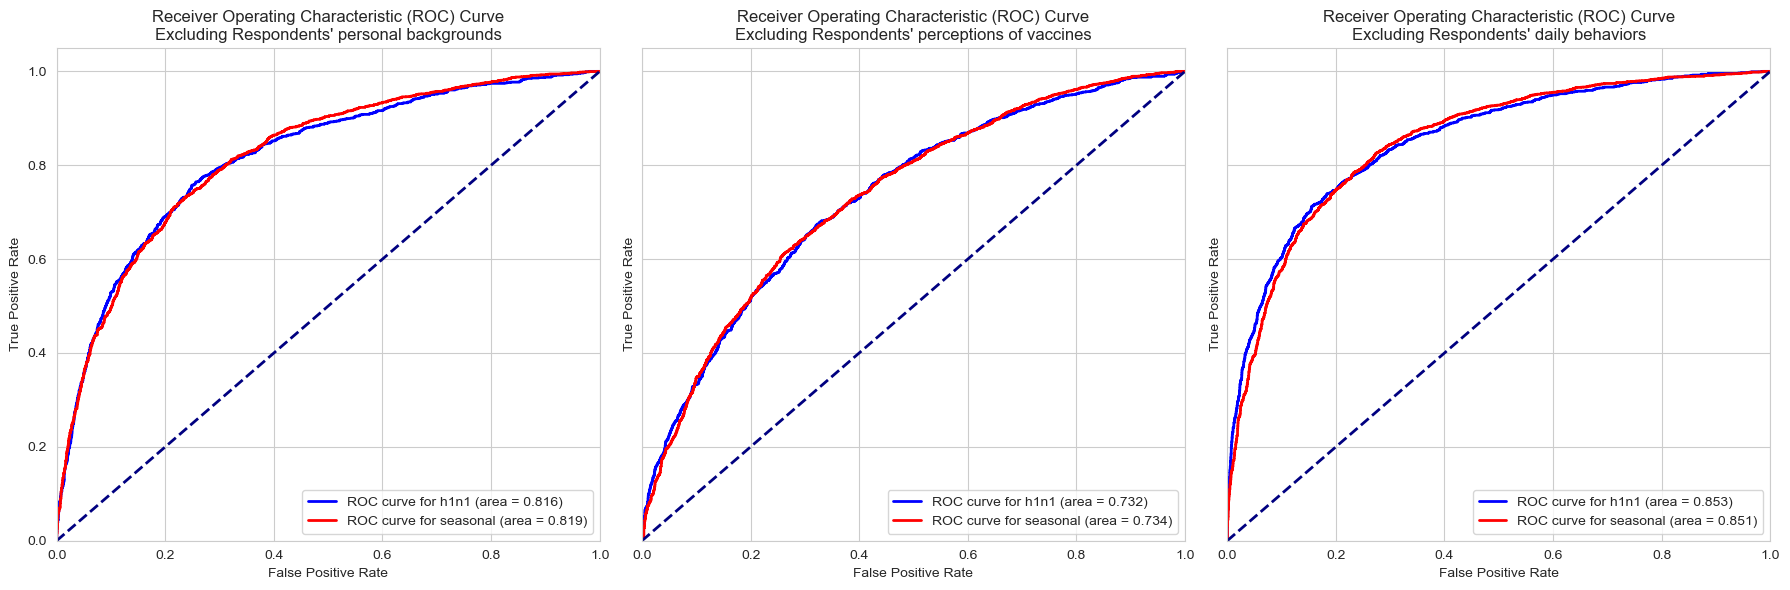

In [24]:
# use neural network
model_n_h1n1 = PyTorchMLPClassifier()
model_n_seasonal = PyTorchMLPClassifier()

best_h1n1_model_n, best_seasonal_model_n = ablation_experiment(feature_groups, train_features_processed, train_labels, model_n_h1n1,model_n_seasonal, 5)

Performing ablation experiment by excluding Respondents' personal backgrounds...
Training and evaluating model for h1n1_vaccine...
Average ROC AUC score for h1n1_vaccine: 0.830
Best H1N1 classification report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     21033
           1       0.64      0.48      0.55      5674

    accuracy                           0.83     26707
   macro avg       0.75      0.70      0.72     26707
weighted avg       0.82      0.83      0.82     26707

Training and evaluating model for seasonal_vaccine...
Average ROC AUC score for seasonal_vaccine: 0.832
Best Seasonal classification report:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78     14272
           1       0.75      0.72      0.74     12435

    accuracy                           0.76     26707
   macro avg       0.76      0.76      0.76     26707
weighted avg       0.76      0.76      0.76     26

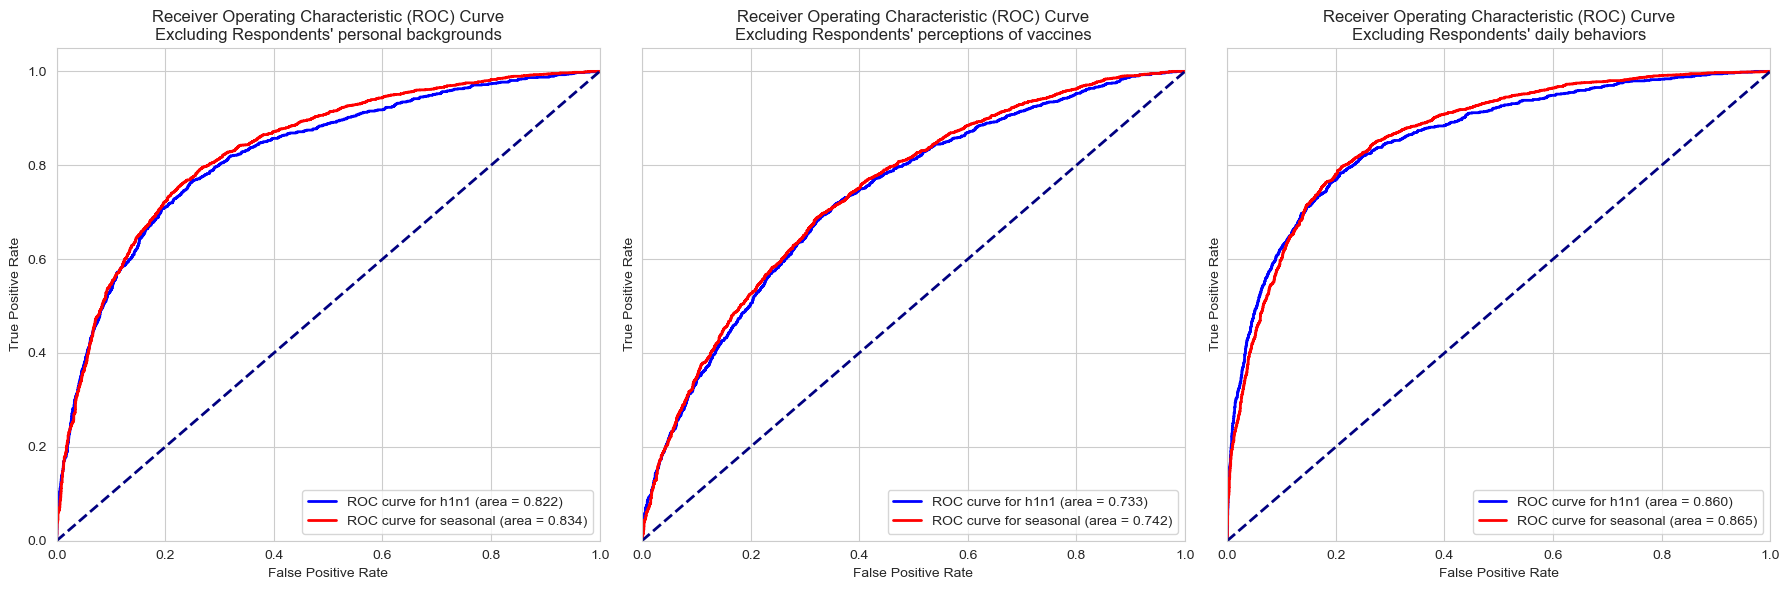

In [25]:
# use catboost
model_c_h1n1_ae = CatBoostClassifier(depth=6, iterations=500, learning_rate=0.05, verbose=False)
model_c_seasonal_ae = CatBoostClassifier(depth=6, iterations=1500, learning_rate=0.01, verbose=False)

best_h1n1_model_c, best_seasonal_model_c = ablation_experiment(feature_groups, train_features_processed, train_labels, model_c_h1n1_ae, model_c_seasonal_ae, 5)

In [26]:
# output the submission file for neural network
X_test_AE = test_features_processed.drop(daily_behaviors, axis=1)
y_h1n1_predict_AE = best_h1n1_model_n.predict_proba(X_test_AE)[:,1]
y_seasonal_predict_AE = best_seasonal_model_n.predict_proba(X_test_AE)[:,1]
test_features = pd.read_csv('test_set_features.csv')
results = pd.DataFrame({'respondent_id': test_features['respondent_id'], 'h1n1_vaccine': y_h1n1_predict_AE , 'seasonal_vaccine': y_seasonal_predict_AE})
# Output the result as csv file
results.to_csv('result/predictions_ablation_experiment_nn_yjz.csv', index=False)

In [27]:
# output the submission file for catboost
X_test_AE = test_features_processed.drop(daily_behaviors, axis=1)
y_h1n1_predict_AE = best_h1n1_model_c.predict_proba(X_test_AE)[:,1]
y_seasonal_predict_AE = best_seasonal_model_c.predict_proba(X_test_AE)[:,1]
results = pd.DataFrame({'respondent_id': test_features['respondent_id'], 'h1n1_vaccine': y_h1n1_predict_AE , 'seasonal_vaccine': y_seasonal_predict_AE})
# Output the result as csv file
results.to_csv('result/predictions_ablation_experiment_catboost_yjz.csv', index=False)

## Part 2
# This section and all following sections were completed by [Yizhen Peng]. <div id="YizhenPeng"></div>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc

# Exploratory Analysis


In [2]:
# Load training dataset
train_data = pd.read_csv('training_set_features.csv')
missing_train_data = train_data.isnull().mean()
missing_train_data = missing_train_data.sort_values(ascending=False)
train_data.describe()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
count,26707.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,...,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000
mean,13353.000000,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,...,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583
std,7709.791156,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,...,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,6676.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,...,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,13353.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,...,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000
75%,20029.500000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,...,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000
max,26706.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000


In [3]:
train_labels = pd.read_csv('training_set_labels.csv')
h1n1_vaccine = train_labels.value_counts('h1n1_vaccine')
seasonal_vaccine = train_labels.value_counts('seasonal_vaccine')
print(h1n1_vaccine)
print(seasonal_vaccine)

h1n1_vaccine
0    21033
1     5674
dtype: int64
seasonal_vaccine
0    14272
1    12435
dtype: int64


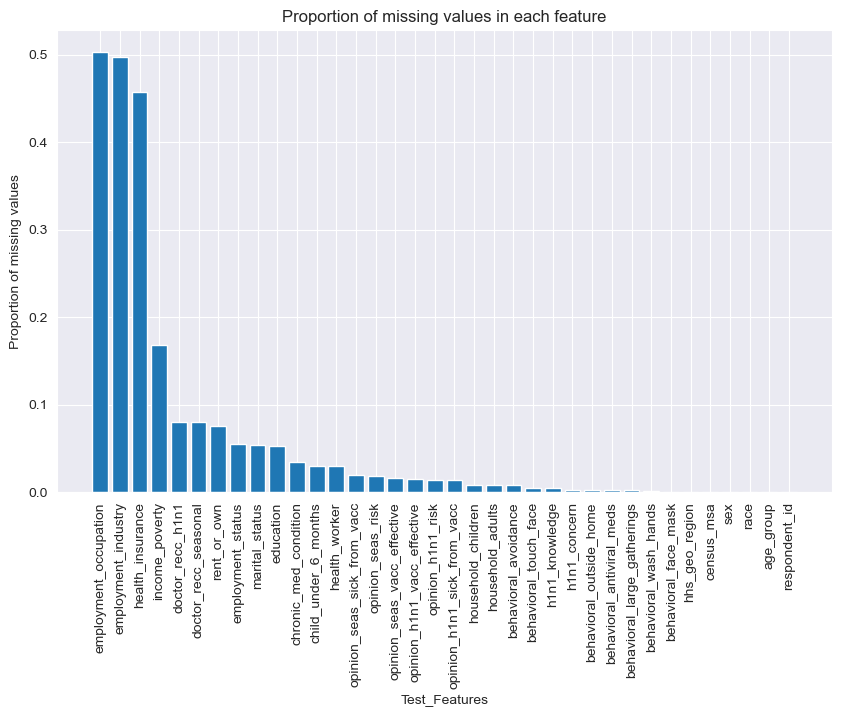

In [4]:
# Load the test dataset
test_data = pd.read_csv('test_set_features.csv')
missing_test_data = test_data.isnull().mean()
missing_test_data = missing_test_data.sort_values(ascending=False)

plt.figure(figsize=(10,6))
plt.xticks(rotation=90)
plt.title('Proportion of missing values in each feature')
plt.xlabel('Test_Features')
plt.ylabel('Proportion of missing values')
plt.bar(missing_test_data.index, missing_test_data.values)
plt.show()

 # Data Processing
 In this part, we will preprocess the training set and test set data, including cleaning the data, filling missing values, and normalizing the data.

In [5]:
# Training dataset processing

# Load data
train_data = pd.read_csv('training_set_features.csv')
train_labels = pd.read_csv('training_set_labels.csv')

# Missing value handling
# Fill missing values
train_data['health_insurance'] = train_data['health_insurance'].fillna('Unknown')
# train_data['employment_industry'] = train_data['employment_industry'].fillna('Unknown')
# train_data['employment_occupation'] = train_data['employment_occupation'].fillna('Unknown')
train_data = train_data.drop(['employment_industry','employment_occupation'], axis=1)
train_data['income_poverty'] = train_data['income_poverty'].replace({
    'Below Poverty': 1,
    '<= $75,000, Above Poverty': 2,
    '> $75,000': 3
})
median_income = train_data['income_poverty'].median()
train_data['income_poverty'] = train_data['income_poverty'].fillna(median_income)
train_data['doctor_recc_seasonal'].fillna(train_data['doctor_recc_seasonal'].mode()[0], inplace=True)
train_data['doctor_recc_h1n1'].fillna(train_data['doctor_recc_h1n1'].mode()[0], inplace=True)
freq = train_data['rent_or_own'].value_counts()
most_common = freq.index[0]
train_data['rent_or_own'].fillna(most_common, inplace=True)
freq1 = train_data['employment_status'].value_counts()
most_common1 = freq1.index[0]
train_data['employment_status'].fillna(most_common1, inplace=True)
str_features = ['marital_status', 'education', 'chronic_med_condition', 'child_under_6_months', 'health_worker',
                'opinion_seas_sick_from_vacc', 'opinion_seas_risk', 'opinion_seas_vacc_effective',
                'opinion_h1n1_sick_from_vacc', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'household_children',
                'household_adults', 'behavioral_touch_face', 'h1n1_knowledge']
for feature in str_features:
    mode_val = train_data[feature].mode()[0]
    train_data[feature] = train_data[feature].fillna(mode_val)

# Delete rows with missing values
drop_features = ['h1n1_concern', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_antiviral_meds',
                 'behavioral_antiviral_meds', 'behavioral_face_mask', 'behavioral_avoidance', 'behavioral_wash_hands']
train_data = train_data.dropna(subset=drop_features)

# One-hot
# cat_columns = ['health_insurance', 'age_group', 'education', 'race', 'sex', 'marital_status', 'employment_status',
#                'rent_or_own', 'census_msa', 'hhs_geo_region','employment_industry','employment_occupation']

# Drop employment_industry ,employment_occupation
cat_columns = ['health_insurance', 'age_group', 'education', 'race', 'sex', 'marital_status', 'employment_status',
               'rent_or_own', 'census_msa', 'hhs_geo_region']

onehot_train_data = pd.get_dummies(train_data[cat_columns])
new_train_features = pd.concat([train_data.drop(cat_columns, axis=1), onehot_train_data], axis=1)

new_train_all_data = new_train_features.merge(train_labels, on='respondent_id')
train_features = new_train_all_data.drop(['h1n1_vaccine', 'seasonal_vaccine'], axis=1)
train_labels = new_train_all_data[['respondent_id','h1n1_vaccine', 'seasonal_vaccine']]


In [6]:
# Test dataset processing
test_data =pd.read_csv('test_set_features.csv')

# Missing value handling
# Fill missing values
test_data['health_insurance'] = test_data['health_insurance'].fillna('Unknown')
# test_data['employment_industry'] = test_data['employment_industry'].fillna('Unknown')
# test_data['employment_occupation'] = test_data['employment_occupation'].fillna('Unknown')

test_data = test_data.drop(['employment_industry','employment_occupation'], axis=1)
test_data['income_poverty'] = test_data['income_poverty'].replace({
    'Below Poverty': 1,
    '<= $75,000, Above Poverty': 2,
    '> $75,000': 3
})
median_income = test_data['income_poverty'].median()
test_data['income_poverty'] = test_data['income_poverty'].fillna(median_income)
test_data['doctor_recc_seasonal'].fillna(test_data['doctor_recc_seasonal'].mode()[0], inplace=True)
test_data['doctor_recc_h1n1'].fillna(test_data['doctor_recc_h1n1'].mode()[0], inplace=True)
freq = test_data['rent_or_own'].value_counts()
most_common = freq.index[0]
test_data['rent_or_own'].fillna(most_common, inplace=True)
freq1 = test_data['employment_status'].value_counts()
most_common1 = freq1.index[0]
test_data['employment_status'].fillna(most_common1, inplace=True)
# str_features = ['marital_status', 'education', 'chronic_med_condition', 'child_under_6_months', 'health_worker',
#                 'opinion_seas_sick_from_vacc', 'opinion_seas_risk', 'opinion_seas_vacc_effective',
#                 'opinion_h1n1_sick_from_vacc', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'household_children',
#                 'household_adults', 'behavioral_touch_face', 'h1n1_knowledge','employment_industry','employment_occupation',
#                 'h1n1_concern', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_antiviral_meds',
#                 'behavioral_antiviral_meds', 'behavioral_face_mask', 'behavioral_avoidance', 'behavioral_wash_hands'
#                 ]

# Drop employment_industry ,employment_occupation
str_features = ['marital_status', 'education', 'chronic_med_condition', 'child_under_6_months', 'health_worker',
                'opinion_seas_sick_from_vacc', 'opinion_seas_risk', 'opinion_seas_vacc_effective',
                'opinion_h1n1_sick_from_vacc', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'household_children',
                'household_adults', 'behavioral_touch_face', 'h1n1_knowledge',
                'h1n1_concern', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_antiviral_meds',
                'behavioral_antiviral_meds', 'behavioral_face_mask', 'behavioral_avoidance', 'behavioral_wash_hands'
                ]
for feature in str_features:
    mode_val = test_data[feature].mode()[0]
    test_data[feature] = test_data[feature].fillna(mode_val)

# One-hot
# cat_columns = ['health_insurance', 'age_group', 'education', 'race', 'sex', 'marital_status', 'employment_status',
#                'rent_or_own', 'census_msa', 'hhs_geo_region','employment_industry','employment_occupation']

cat_columns = ['health_insurance', 'age_group', 'education', 'race', 'sex', 'marital_status', 'employment_status',
               'rent_or_own', 'census_msa', 'hhs_geo_region']
onehot_test_data = pd.get_dummies(test_data[cat_columns])
new_test_data = pd.concat([test_data.drop(cat_columns, axis=1), onehot_test_data], axis=1)


# Normalization


In [7]:
#Train data
# Create a normalizer
scaler = StandardScaler()
features_to_scale = train_features.drop('respondent_id', axis=1).columns

# Fit and normalize transformation on training data
train_features_scaled = train_features.copy()
train_features_scaled[features_to_scale] = scaler.fit_transform(train_features[features_to_scale])
train_features_scaled = train_features_scaled.drop('respondent_id', axis=1)

# Replace old training data with new normalized training data
train_features = train_features_scaled

In [8]:
#Test data
# Create a normalizer
scaler = StandardScaler()
features_to_scale = new_test_data.drop('respondent_id', axis=1).columns

# Fit and normalize transformation on test data
scaler.fit(train_features[features_to_scale])
new_test_data_scaled = new_test_data.copy()
new_test_data_scaled[features_to_scale] = scaler.transform(new_test_data[features_to_scale])
new_test_data_scaled = new_test_data_scaled.drop('respondent_id', axis=1)

# Replace old training data with new normalized training data
new_test_data = new_test_data_scaled


# Data imbalance handling - undersampling
In this section, we undersample the dataset to address the data imbalance. Data imbalance means that in our dataset, the difference in the number of samples between the two categories of `h1n1_vaccine` is too large.  Our goal is to close this gap through undersampling. Specifically, we will reduce the number of samples where `h1n1_vaccine` is 0 to the same number of samples where `h1n1_vaccine` is 1.


In [9]:
def undersample_data(X, y):
    # Combine features and label
    data = pd.concat([X, y], axis=1)

    # Split data based on label
    class_0 = data[y['h1n1_vaccine'] == 0]
    class_1 = data[y['h1n1_vaccine'] == 1]

    # Perform undersampling
    class_0_undersampled = resample(class_0, replace=False, n_samples=len(class_1))

    # Concatenate undersampled class_0 and class_1
    undersampled_data = pd.concat([class_0_undersampled, class_1])

    # Shuffle data
    undersampled_data = undersampled_data.sample(frac=1, random_state=42)

    # Split undersampled_data back into features and label
    X_undersampled = undersampled_data.drop(['respondent_id', 'h1n1_vaccine'], axis=1)
    y_undersampled = undersampled_data[['respondent_id', 'h1n1_vaccine']]

    return X_undersampled, y_undersampled

# Train and evaluate random forest model
 In this part, we will use a random forest model for training and prediction. We will train and predict for two labels `h1n1_vaccine` and `seasonal_vaccine` respectively.

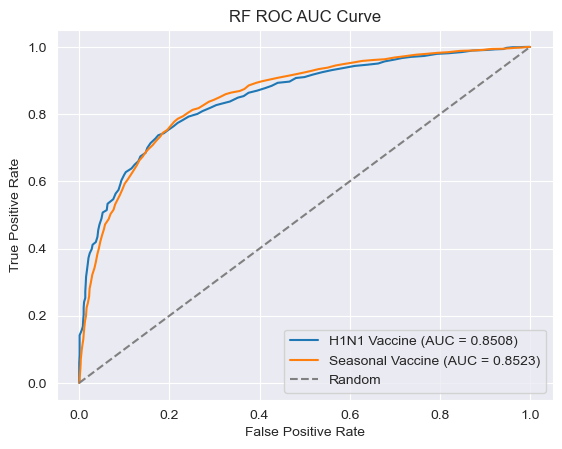

In [13]:
# Random Forest without parameters
y_h1n1 = train_labels[['respondent_id', 'h1n1_vaccine']]
train_features_undersampled, y_h1n1_undersampled = undersample_data(train_features, y_h1n1)

# Split into training and validation sets
X_train_h1n1, X_val_h1n1, y_train_h1n1, y_val_h1n1 = train_test_split(train_features_undersampled, y_h1n1_undersampled['h1n1_vaccine'], test_size=0.2, random_state=42)

# Train the model
tree_h1n1 = RandomForestClassifier()
tree_h1n1.fit(X_train_h1n1, y_train_h1n1)

# Predict probabilities and compute ROC and AUC
y_h1n1_predict = tree_h1n1.predict_proba(X_val_h1n1)[:,1]
fpr1, tpr1, _ = roc_curve(y_val_h1n1, y_h1n1_predict)
auc1 = roc_auc_score(y_val_h1n1, y_h1n1_predict)

# 'seasonal_vaccine' training
y_seasonal = train_labels['seasonal_vaccine']
X_train_seasonal, X_val_seasonal, y_train_seasonal, y_val_seasonal = train_test_split(train_features, y_seasonal, test_size=0.2, random_state=42)

# Train the model
tree_seasonal = RandomForestClassifier()
tree_seasonal.fit(X_train_seasonal, y_train_seasonal)

# Predict probabilities and compute ROC and AUC
y_seasonal_predict = tree_seasonal.predict_proba(X_val_seasonal)[:,1]
fpr2, tpr2, _ = roc_curve(y_val_seasonal, y_seasonal_predict)
auc2 = roc_auc_score(y_val_seasonal, y_seasonal_predict)


# y_h1n1_pred = tree_h1n1.predict(X_val_h1n1)
# accuracy_h1n1 = accuracy_score(y_val_h1n1, y_h1n1_pred)
# print(f'H1N1 Vaccine Accuracy: {accuracy_h1n1:.4f}')
# recall_h1n1 = recall_score(y_val_h1n1, y_h1n1_pred)
# print(f'H1N1 Vaccine Recall: {recall_h1n1:.4f}')
# f1_h1n1 = f1_score(y_val_h1n1, y_h1n1_pred)
# print(f'H1N1 Vaccine F1 Score: {f1_h1n1:.4f}')
#
# y_seasonal_pred = tree_seasonal.predict(X_val_seasonal)
# accuracy_seasonal = accuracy_score(y_val_seasonal, y_seasonal_pred)
# print(f'Seasonal Vaccine Accuracy: {accuracy_seasonal:.4f}')
# recall_seasonal = recall_score(y_val_seasonal, y_seasonal_pred)
# print(f'Seasonal Vaccine Recall: {recall_seasonal:.4f}')
# f1_seasonal = f1_score(y_val_seasonal, y_seasonal_pred)
# print(f'Seasonal Vaccine F1 Score: {f1_seasonal:.4f}')

# Draw the ROC curve
plt.figure()
plt.plot(fpr1, tpr1, label=f'H1N1 Vaccine (AUC = {auc1:.4f})')
plt.plot(fpr2, tpr2, label=f'Seasonal Vaccine (AUC = {auc2:.4f})')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF ROC AUC Curve')
plt.legend(loc='lower right')
plt.show()


# GridSearch
In this part, we will tune the hyperparameters of the random forest model and LogisticRegression. We will use the GridSearchCV method to find the best combination of hyperparameters

In [11]:
# Define the parameter combinations to try
param_grid = {
    'max_depth': [10, 15, 20],
    'min_samples_leaf': [1, 2, 3],
    'n_estimators': [100, 200, 300]
}

# Initialize the GridSearchCV object with random_state set
grid_h1n1 = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_seasonal = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)

grid_h1n1.fit(X_train_h1n1, y_train_h1n1)
grid_seasonal.fit(X_train_seasonal, y_train_seasonal)

# Output the best parameters
print("Best parameters RF for h1n1 data: ", grid_h1n1.best_params_)
print("Best parameters RF for seasonal data: ", grid_seasonal.best_params_)

Best parameters RF for h1n1 data:  {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 200}
Best parameters RF for seasonal data:  {'max_depth': 20, 'min_samples_leaf': 3, 'n_estimators': 300}


In [12]:
# Define the parameter combinations to try
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_h1n1 = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_seasonal = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, n_jobs=-1)

# Grid search on the training data
grid_h1n1.fit(X_train_h1n1, y_train_h1n1)
grid_seasonal.fit(X_train_seasonal, y_train_seasonal)

# Output the best parameters
print("Best parameters LG for h1n1 data:", grid_h1n1.best_params_)
print("Best parameters LG for seasonal data:", grid_seasonal.best_params_)

/Users/easonpeng/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/easonpeng/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/easonpeng/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/easonpeng/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/easonpeng/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/easonpeng/anaconda3/lib/python3.10/sit

Best parameters LG for h1n1 data: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best parameters LG for seasonal data: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


# Random Forest with parameters
This part we use the parameters given by grid search for random forest model training

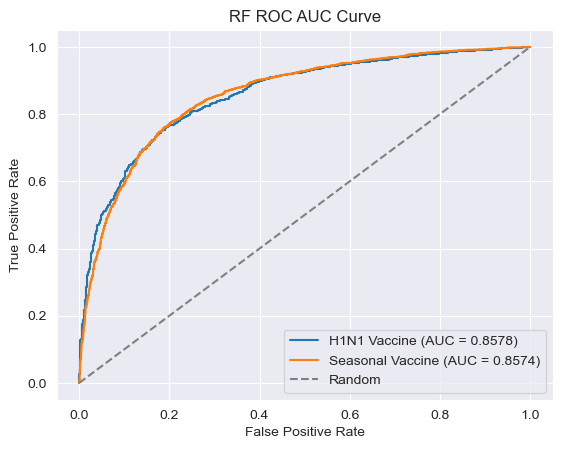

In [14]:
# Random Forest with parameters

y_h1n1 = train_labels[['respondent_id', 'h1n1_vaccine']]
train_features_undersampled, y_h1n1_undersampled = undersample_data(train_features, y_h1n1)

# Split into training and validation sets
X_train_h1n1, X_val_h1n1, y_train_h1n1, y_val_h1n1 = train_test_split(train_features_undersampled, y_h1n1_undersampled['h1n1_vaccine'], test_size=0.2, random_state=42)

# Train the model
tree_h1n1 = RandomForestClassifier(max_depth = 15,min_samples_leaf = 2,n_estimators = 300)
tree_h1n1.fit(X_train_h1n1, y_train_h1n1)

# Predict probabilities and compute ROC and AUC
y_h1n1_predict = tree_h1n1.predict_proba(X_val_h1n1)[:,1]
fpr1, tpr1, _ = roc_curve(y_val_h1n1, y_h1n1_predict)
auc1 = roc_auc_score(y_val_h1n1, y_h1n1_predict)

# 'seasonal_vaccine' training
y_seasonal = train_labels['seasonal_vaccine']
X_train_seasonal, X_val_seasonal, y_train_seasonal, y_val_seasonal = train_test_split(train_features, y_seasonal, test_size=0.2, random_state=42)

# Train the model
tree_seasonal = RandomForestClassifier(max_depth = 20,min_samples_leaf = 3,n_estimators = 300)
tree_seasonal.fit(X_train_seasonal, y_train_seasonal)

# Predict probabilities and compute ROC and AUC
y_seasonal_predict = tree_seasonal.predict_proba(X_val_seasonal)[:,1]
fpr2, tpr2, _ = roc_curve(y_val_seasonal, y_seasonal_predict)
auc2 = roc_auc_score(y_val_seasonal, y_seasonal_predict)

# y_h1n1_pred = tree_h1n1.predict(X_val_h1n1)
# accuracy_h1n1 = accuracy_score(y_val_h1n1, y_h1n1_pred)
# print(f'H1N1 Vaccine Accuracy: {accuracy_h1n1:.4f}')
# recall_h1n1 = recall_score(y_val_h1n1, y_h1n1_pred)
# print(f'H1N1 Vaccine Recall: {recall_h1n1:.4f}')
# f1_h1n1 = f1_score(y_val_h1n1, y_h1n1_pred)
# print(f'H1N1 Vaccine F1 Score: {f1_h1n1:.4f}')
#
# y_seasonal_pred = tree_seasonal.predict(X_val_seasonal)
# accuracy_seasonal = accuracy_score(y_val_seasonal, y_seasonal_pred)
# print(f'Seasonal Vaccine Accuracy: {accuracy_seasonal:.4f}')
# recall_seasonal = recall_score(y_val_seasonal, y_seasonal_pred)
# print(f'Seasonal Vaccine Recall: {recall_seasonal:.4f}')
# f1_seasonal = f1_score(y_val_seasonal, y_seasonal_pred)
# print(f'Seasonal Vaccine F1 Score: {f1_seasonal:.4f}')

# Draw the ROC curve
plt.figure()
plt.plot(fpr1, tpr1, label=f'H1N1 Vaccine (AUC = {auc1:.4f})')
plt.plot(fpr2, tpr2, label=f'Seasonal Vaccine (AUC = {auc2:.4f})')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF ROC AUC Curve')
plt.legend(loc='lower right')
plt.show()

# Model Prediction
This part uses the random forest model to predict the test set data and save it to the csv file

In [15]:
X_test_all = new_test_data
y_h1n1_predict = tree_h1n1.predict_proba(X_test_all)[:,1]
y_seasonal_predict = tree_seasonal.predict_proba(X_test_all)[:,1]
results = pd.DataFrame({ 'respondent_id': test_data['respondent_id'],'h1n1_vaccine': y_h1n1_predict , 'seasonal_vaccine': y_seasonal_predict})
# Save as csv file
results.to_csv('result/predictions_RF_ALL_F_pyz.csv', index=False)

# Ablation Experiment
 In this section, we will conduct an Ablation experiment through which we can understand the impact of each feature group on the model's predictive performance. We will conduct experiments separately for `h1n1_vaccine` and `seasonal_vaccine`.

In [20]:

# Define an ablation experiment
def ablation_experiment_v2(feature_groups, train_features, train_labels, model,k):
    best_auc_h1n1 = 0
    best_auc_seasonal = 0
    best_h1n1_model = None
    best_seasonal_model = None

    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, (group_name, feature_group) in enumerate(feature_groups.items()):
        print(f'Performing ablation experiment by excluding {group_name}...')

        # Remove the feature group from training data
        features_to_remove = feature_group
        features_filtered = train_features.drop(features_to_remove, axis=1)

        # Initialize cross-validation
        skf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)

        for target_label, color in zip(['h1n1_vaccine', 'seasonal_vaccine'], ['b', 'r']):
            print(f'Training and evaluating model for {target_label}...')
            aucs = []
            accuracies = []
            precisions = []
            recalls = []
            f1s = []
            for train_index, val_index in skf.split(features_filtered, train_labels[target_label]):

                X_train, X_val = features_filtered.iloc[train_index], features_filtered.iloc[val_index]
                y_train, y_val = train_labels[target_label].iloc[train_index], train_labels[target_label].iloc[val_index]

                # Perform under-sampling if target_label is 'h1n1_vaccine'
                if target_label == 'h1n1_vaccine':
                    undersampler = RandomUnderSampler(random_state=42)
                    X_train, y_train = undersampler.fit_resample(X_train, y_train)


                # Train the model
                model.fit(X_train, y_train)

                # Predict probabilities
                probabilities = model.predict_proba(X_val)
                predictions = model.predict(X_val)

                accuracies.append(accuracy_score(y_val, predictions))
                precisions.append(precision_score(y_val, predictions))
                recalls.append(recall_score(y_val, predictions))
                f1s.append(f1_score(y_val, predictions))

                # Compute ROC curve and ROC area
                fpr, tpr, _ = roc_curve(y_val, probabilities[:, 1])
                roc_auc = auc(fpr, tpr)
                aucs.append(roc_auc)


            mean_auc = np.mean(aucs)
            # mean_accuracy = np.mean(accuracies)
            # mean_precision = np.mean(precisions)
            # mean_recall = np.mean(recalls)
            # mean_f1 = np.mean(f1s)
            print(f'Average ROC AUC score for {target_label}: {mean_auc:.3f}')
            # print(f'Average accuracy for {target_label}: {mean_accuracy:.3f}')
            # print(f'Average precision for {target_label}: {mean_precision:.3f}')
            # print(f'Average recall for {target_label}: {mean_recall:.3f}')
            # print(f'Average F1 score for {target_label}: {mean_f1:.3f}')

            # Update the best model if current model is better
            if target_label == 'h1n1_vaccine' and mean_auc > best_auc_h1n1:
                best_auc_h1n1 = mean_auc
                best_h1n1_model = model
            elif target_label == 'seasonal_vaccine' and mean_auc > best_auc_seasonal:
                best_auc_seasonal = mean_auc
                best_seasonal_model = model

            # Set the current subplot to be the active one
            plt.sca(axes[i])

            # Plot ROC curve
            plt.plot(fpr, tpr, color=color, lw=2, label=f'ROC curve for {target_label} (area = {roc_auc:.3f})')

        # Plot settings
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic (ROC) Curve\nExcluding {group_name}')
        plt.legend(loc="lower right")

    # Show the plot
    plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure.
    plt.show()

    return best_h1n1_model, best_seasonal_model


# Group features
In this section, we classify the features so that in the subsequent Ablation experiment, we can understand the impact of each feature group on the performance of the model.

In [21]:
# Respondents' personal backgrounds
personal_backgrounds = [
    'age_group',
    'education',
    'race',
    'sex',
    'income_poverty',
    'marital_status',
    'rent_or_own',
    'employment_status',
    'hhs_geo_region',
    'census_msa',
    'household_adults',
    'household_children',
    # 'employment_industry',
    # 'employment_occupation',
    'health_worker',
    'health_insurance',
    'chronic_med_condition',
    'child_under_6_months'
]

# Respondents' perceptions of vaccines
perceptions_of_vaccines = [
    'h1n1_concern',
    'h1n1_knowledge',
    'doctor_recc_h1n1',
    'doctor_recc_seasonal',
    'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk',
    'opinion_h1n1_sick_from_vacc',
    'opinion_seas_vacc_effective',
    'opinion_seas_risk',
    'opinion_seas_sick_from_vacc'
]

# Respondents' daily behaviors
daily_behaviors = [
    'behavioral_antiviral_meds',
    'behavioral_avoidance',
    'behavioral_face_mask',
    'behavioral_wash_hands',
    'behavioral_large_gatherings',
    'behavioral_outside_home',
    'behavioral_touch_face'
]

# One-hot encoded columns
onehot_columns = onehot_train_data.columns.tolist()

# Replace the one-hot encoded features in the original feature list with the encoded columns
personal_backgrounds = [col for col in personal_backgrounds if col not in cat_columns] + [col for col in onehot_columns if col.startswith(tuple(personal_backgrounds))]
perceptions_of_vaccines = [col for col in perceptions_of_vaccines if col not in cat_columns] + [col for col in onehot_columns if col.startswith(tuple(perceptions_of_vaccines))]
daily_behaviors = [col for col in daily_behaviors if col not in cat_columns] + [col for col in onehot_columns if col.startswith(tuple(daily_behaviors))]

feature_groups = {
    "Respondents' personal backgrounds": personal_backgrounds,
    "Respondents' perceptions of vaccines": perceptions_of_vaccines,
    "Respondents' daily behaviors": daily_behaviors
}

# Train Random Forest and Logistic Regression models
In this section, we will perform the following steps:
 1. **Train the random forest model**: We use the best parameters found by GridSearchCV to train the random forest model, and then pass the model and data into the Ablation we defined earlier experimental function. We will train two models, one to predict `h1n1_vaccine` and one to predict `seasonal_vaccine`.
 2. **Train the logistic regression model**: We use the best parameters found by GridSearchCV to train the logistic regression model, and then pass the model and data into the Ablation experiment function we defined earlier. We will train two models, one to predict `h1n1_vaccine` and one to predict `seasonal_vaccine`.

In this way, we can understand which model is more suitable for our data by comparing the performance of the two models in the Ablation experiment, and can better understand the impact of individual feature groups on the prediction results.

Performing ablation experiment by excluding Respondents' personal backgrounds...
Training and evaluating model for h1n1_vaccine...
Average ROC AUC score for h1n1_vaccine: 0.822
Training and evaluating model for seasonal_vaccine...
Average ROC AUC score for seasonal_vaccine: 0.825
Performing ablation experiment by excluding Respondents' perceptions of vaccines...
Training and evaluating model for h1n1_vaccine...
Average ROC AUC score for h1n1_vaccine: 0.733
Training and evaluating model for seasonal_vaccine...
Average ROC AUC score for seasonal_vaccine: 0.727
Performing ablation experiment by excluding Respondents' daily behaviors...
Training and evaluating model for h1n1_vaccine...
Average ROC AUC score for h1n1_vaccine: 0.860
Training and evaluating model for seasonal_vaccine...
Average ROC AUC score for seasonal_vaccine: 0.855


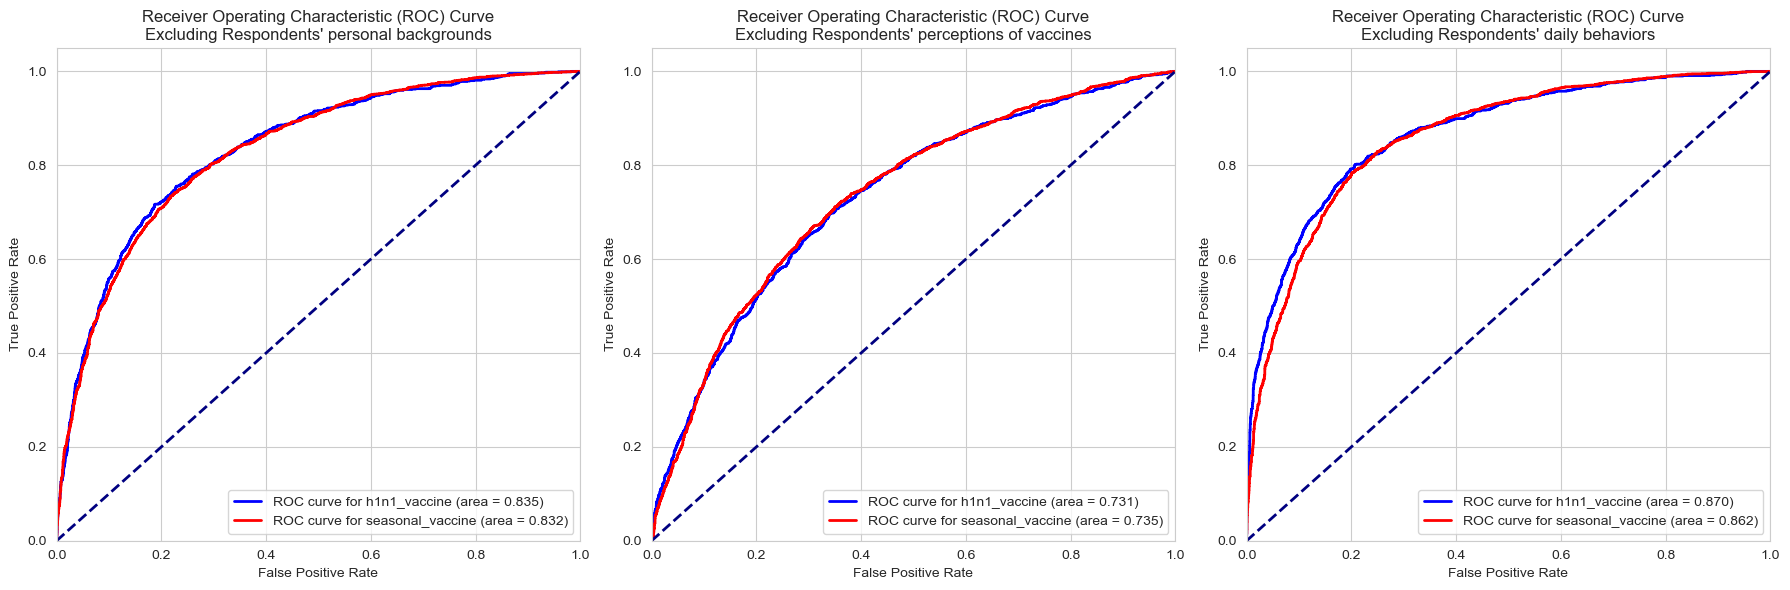

In [22]:
# Train Random Forest
RF_model = RandomForestClassifier(max_depth=15, min_samples_leaf=2, n_estimators=300, random_state=42)
best_h1n1_model, best_seasonal_model = ablation_experiment_v2(feature_groups, train_features, train_labels, RF_model, 5)

Performing ablation experiment by excluding Respondents' personal backgrounds...
Training and evaluating model for h1n1_vaccine...
Average ROC AUC score for h1n1_vaccine: 0.823
Training and evaluating model for seasonal_vaccine...
Average ROC AUC score for seasonal_vaccine: 0.821
Performing ablation experiment by excluding Respondents' perceptions of vaccines...
Training and evaluating model for h1n1_vaccine...
Average ROC AUC score for h1n1_vaccine: 0.733
Training and evaluating model for seasonal_vaccine...
Average ROC AUC score for seasonal_vaccine: 0.734
Performing ablation experiment by excluding Respondents' daily behaviors...
Training and evaluating model for h1n1_vaccine...
Average ROC AUC score for h1n1_vaccine: 0.855
Training and evaluating model for seasonal_vaccine...
Average ROC AUC score for seasonal_vaccine: 0.852


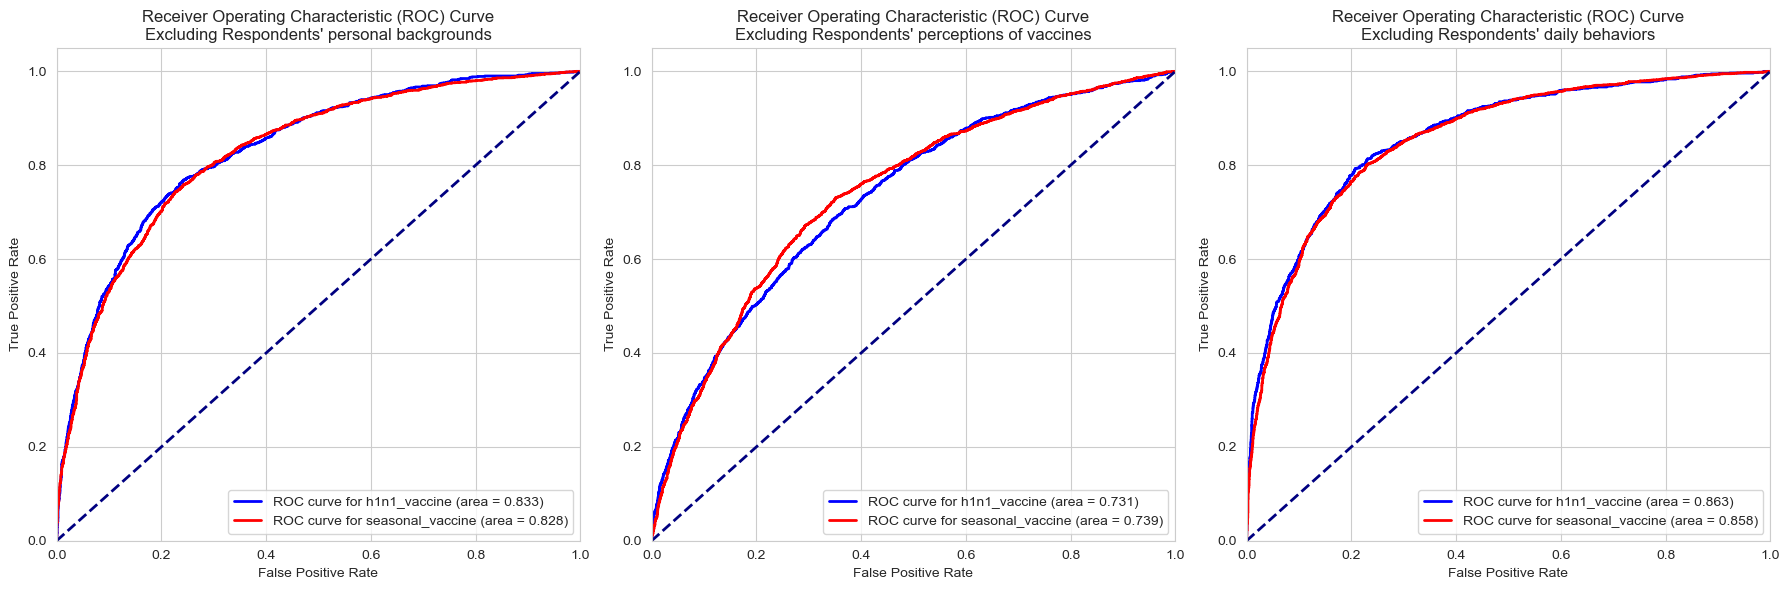

In [23]:
# Train Logistic Regression
logreg_model = LogisticRegression(C=1.0, penalty='l2', solver='liblinear')
best_h1n1_model2, best_seasonal_model2 = ablation_experiment_v2(feature_groups, train_features, train_labels, logreg_model, 5)

# Generate and save prediction results

In [24]:
X_test_AE = new_test_data.drop(daily_behaviors, axis =1)
y_h1n1_predict_AE = best_h1n1_model.predict_proba(X_test_AE)[:,1]
y_seasonal_predict_AE = best_seasonal_model.predict_proba(X_test_AE)[:,1]
results = pd.DataFrame({'respondent_id': test_data['respondent_id'], 'h1n1_vaccine': y_h1n1_predict_AE , 'seasonal_vaccine': y_seasonal_predict_AE})
# Output the result as csv file
results.to_csv('result/predictions_ablation_experiment_pyz.csv', index=False)